In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
# Dataset Class
class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5):
        self.data = []
        self.sequence_length = sequence_length
        self.preprocess_data(directory)

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                speed = float(filename.split('_')[-1].replace('.txt', ''))
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    track_data = {}
                    for line in file:
                        frame, track_id, x1, y1, x2, y2 = map(float, line.strip().split(',')[:6])
                        if track_id not in track_data:
                            track_data[track_id] = []
                        track_data[track_id].append([x1,y1,x2,y2,(x1+x2)/2, (y1+y2)/2, (x1-x2),(y1-y2)])

                    for track_id, frames in track_data.items():
                        if len(frames) >= self.sequence_length:
                            features = []
                            for i in range(1, len(frames)):
                                current_frame = frames[i]
                                previous_frame = frames[i-1]
                                data_d = []
                                distance = 0
                                distance1 = 0
                                distance2 = 0
                                for i in range(4):
                                    data_d.append(( current_frame[i])/1000)
                                for i in range(4):
                                    data_d.append(abs(current_frame[i] - previous_frame[i]))
                                for j in range(4,6):
                                    distance = ((current_frame[j] - previous_frame[j])**2) + distance
                                for j in range(0,2):
                                    distance1 = ((current_frame[j] - previous_frame[j])**2) + distance1
                                for j in range(2,4):
                                    distance2 = ((current_frame[j] - previous_frame[j])**2) + distance2
                                
                                data_d.append(math.sqrt(distance/0.03))
                                data_d.append(math.sqrt(distance1/0.03))
                                data_d.append(math.sqrt(distance2/0.03))
                                data_d.append(abs(current_frame[6]))
                                data_d.append(abs(current_frame[7]))
                                data_d.append(abs(current_frame[6] *current_frame[7]))
                                for i in range(4):
                                    data_d.append(( previous_frame[i])/1000)
                                features.append(data_d)
                            num_sequences = len(features) // self.sequence_length
                            for i in range(num_sequences):
                                start_idx = i * self.sequence_length
                                end_idx = start_idx + self.sequence_length
                                sequence = features[start_idx:end_idx]
                                self.data.append((sequence, speed))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

In [12]:
import torch

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        self.embedding = nn.Conv1d(in_channels=feature_size, out_channels=hidden_dim, kernel_size=1)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, dropout=0.4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = x.permute(1, 0, 2)  
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Switch back to (batch, seq_len, features)
        x = x[:, -1, :]  # Only use the last sequence output for prediction
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)


In [28]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            inputs, speeds = inputs.to(device), speeds.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze() 
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]  
            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                inputs, speeds= inputs.to(device), speeds.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze()  
                if outputs.shape != speeds.shape:
                    outputs = outputs[:speeds.size(0)]  
                loss = torch.sqrt(criterion(outputs, speeds))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch+1}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, RMSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [29]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

train_dataset = SpeedDataset('outputs', sequence_length=15)
test_dataset = SpeedDataset('test_outputs', sequence_length=15)  
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [36]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeedPredictor(sequence_length=15, feature_size=18, hidden_dim=128, output_size=1)
model.to(device)
model.apply(init_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Scheduler for learning rate adjustment
scheduler = ExponentialLR(optimizer, gamma=0.9999999999)
train_losses,val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=200)

Epoch 1/200, MSE training Loss: 957.9034, RMSE validation Loss: 20.3132
Epoch 11/200, MSE training Loss: 543.8750, RMSE validation Loss: 20.0853
Epoch 21/200, MSE training Loss: 479.9059, RMSE validation Loss: 21.9100
Epoch 31/200, MSE training Loss: 418.9700, RMSE validation Loss: 20.3483
Epoch 41/200, MSE training Loss: 405.0953, RMSE validation Loss: 20.0182
Epoch 51/200, MSE training Loss: 400.6630, RMSE validation Loss: 19.9926
Epoch 61/200, MSE training Loss: 400.2843, RMSE validation Loss: 19.9732
Epoch 71/200, MSE training Loss: 400.4511, RMSE validation Loss: 19.9679
Epoch 81/200, MSE training Loss: 401.0721, RMSE validation Loss: 19.9699
Epoch 91/200, MSE training Loss: 400.0426, RMSE validation Loss: 19.9707
Epoch 101/200, MSE training Loss: 400.9180, RMSE validation Loss: 19.9674
Epoch 111/200, MSE training Loss: 400.0641, RMSE validation Loss: 19.9789
Epoch 121/200, MSE training Loss: 400.7793, RMSE validation Loss: 19.9703
Epoch 131/200, MSE training Loss: 401.0689, RMSE 

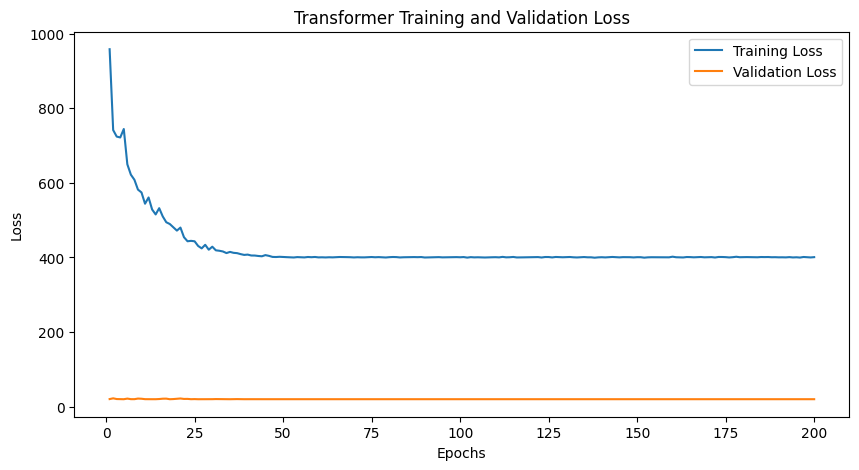

In [37]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 200+1), train_losses, label='Training Loss')
plt.plot(range(1, 200+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer Training and Validation Loss')
plt.legend()
plt.show()

In [38]:

torch.save(model, 'Transformer_Regression_150.pth')


In [39]:
# Load the entire model
model = torch.load('Transformer_Regression_150.pth').to(device)
model.eval()  # Set the model to evaluation mode


SpeedPredictor(
  (embedding): Conv1d(18, 128, kernel_size=(1,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=

In [41]:
import random
def predict_and_compare(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())  
            loss = torch.sqrt(criterion(outputs, targets))
            if outputs.shape != targets.shape:
                outputs = outputs[:targets.size(0)] 
            total_loss += loss.item()
    return predictions, actuals, total_loss/len(test_loader)

test_dataset = SpeedDataset('test_outputs', sequence_length=15)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions, actuals, loss = predict_and_compare(model, test_loader)

def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")

# Assuming you have already executed the predict_and_compare function
# predictions, actuals = predict_and_compare(model, val_loader)

# Now print randomly selected 30 predictions and their actual values
print_random_predictions(predictions, actuals, 50)
print(loss)


Predicted: 61.1622, Actual: 84.0000
Predicted: 61.1622, Actual: 71.0000
Predicted: 61.1622, Actual: 94.0000
Predicted: 61.1622, Actual: 35.0000
Predicted: 61.1622, Actual: 82.0000
Predicted: 61.1622, Actual: 86.0000
Predicted: 61.1622, Actual: 38.0000
Predicted: 61.1622, Actual: 68.0000
Predicted: 61.1622, Actual: 36.0000
Predicted: 61.1622, Actual: 64.0000
Predicted: 61.1622, Actual: 74.0000
Predicted: 61.1622, Actual: 84.0000
Predicted: 61.1622, Actual: 77.0000
Predicted: 61.1622, Actual: 44.0000
Predicted: 61.1622, Actual: 48.0000
Predicted: 61.1622, Actual: 98.0000
Predicted: 61.1622, Actual: 52.0000
Predicted: 61.1622, Actual: 70.0000
Predicted: 61.1622, Actual: 70.0000
Predicted: 61.1622, Actual: 54.0000
Predicted: 61.1622, Actual: 87.0000
Predicted: 61.1622, Actual: 52.0000
Predicted: 61.1622, Actual: 66.0000
Predicted: 61.1622, Actual: 91.0000
Predicted: 61.1622, Actual: 91.0000
Predicted: 61.1622, Actual: 77.0000
Predicted: 61.1622, Actual: 52.0000
Predicted: 61.1622, Actual: 